In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))
from deepexplain.tensorflow import DeepExplain

/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #2
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #3
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #4
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #5
  (fname, cnt))
/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/ptien/.matplotlib/matplotlibrc", line #6
  (fname, cnt))
/Users/ptien/miniconda/envs/py

In [8]:
%matplotlib inline
import pandas as pd
import PIL
import tensorflow as tf
import numpy as np

In [3]:
model = tf.keras.models.load_model("/Users/ptien/DeepLearning/research/gan/apple2orange.h5")

W0326 16:48:56.602988 140736641745856 deprecation.py:506] From /Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0326 16:48:56.604578 140736641745856 deprecation.py:506] From /Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0326 16:48:56.646208 140736641745856 deprecation.py:506] From /Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/tensorflow_core/python/ops/re

In [4]:
file_name = ["n07740461_10011.jpg", "n07740461_240.jpg", "n07740461_14960.jpg", "n07740461_2770.jpg"]
labels = [0, 0, 0, 0]
assert len(labels) == len(file_name), "length of labels and file_name should be the same."
num_class = 2
image_array = []
base_image_array = []
for f in file_name:
    imag_path =  "/Users/ptien/tfds-download/apple2orange/testA/" + f
    base_path = "/Users/ptien/tfds-download/apple2orange/experiment/generated_y/generated_from_" + f
    imag_temp = tf.keras.preprocessing.image.load_img(imag_path, target_size=(256, 256, 3))
    base_imag_temp = tf.keras.preprocessing.image.load_img(base_path, target_size=(256, 256, 3))
    input_np= tf.keras.preprocessing.image.img_to_array(imag_temp)/255.
    base_input_np = tf.keras.preprocessing.image.img_to_array(base_imag_temp)/255.
    image_array += [input_np]
    base_image_array += [base_input_np]

In [5]:
# imag = np.array(np.expand_dims(input_np, axis=0), dtype=np.float)
# base_imag = np.array(np.expand_dims(base_input_np, axis=0), dtype=np.float)
imag = np.array(image_array, dtype=np.float)
base_imag = np.array(base_image_array, dtype=np.float)
y_label = labels # apple

In [6]:
# %%time
with DeepExplain(session=tf.keras.backend.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    # fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    fModel = tf.keras.models.Model(inputs=model.input, outputs = model.output)
    target_tensor = fModel(input_tensor) # fModel(input_tensor)
    
    # xs = x_test[0:10]
    # ys = y_test[0:10]
    xs = imag
    # ys = np.array([tf.keras.utils.to_categorical(y_label, 2)])
    ys = tf.keras.utils.to_categorical(y_label, num_class)
    
    # attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig_base_line = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys,baseline=base_imag[0])
    attributions_dl = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_dl_base_line = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys,baseline=base_imag[0])
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

W0326 16:49:39.048181 140736641745856 module_wrapper.py:139] From /Users/ptien/DeepLearning/DeepExplain/deepexplain/tensorflow/methods.py:638: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0326 16:49:39.051115 140736641745856 module_wrapper.py:139] From /Users/ptien/DeepLearning/DeepExplain/deepexplain/tensorflow/methods.py:76: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0326 17:01:09.389309 140736641745856 deprecation.py:323] From /Users/ptien/DeepLearning/DeepExplain/deepexplain/tensorflow/methods.py:369: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
a1 = attributions_ig[0]
a2 = attributions_ig_base_line[0]
a3 = attributions_dl[0]
a4 = attributions_dl_base_line[0]

Text(0.5,1,'deeplift_base')

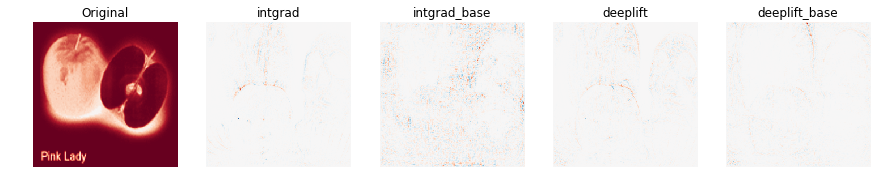

In [58]:

from utils import plot, plt
n_rows = int(len(attributions_ig) / 2)
n_cols = 5
n_rows = 1
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(3*n_cols, 3*n_rows))
plot(xs[0], axis=axes[0]).set_title('Original')
plot(a1, axis=axes[1]).set_title('intgrad')
plot(a2, axis=axes[2]).set_title('intgrad_base')
plot(a3, axis=axes[3]).set_title('deeplift')
plot(a4, axis=axes[4]).set_title('deeplift_base')

In [47]:
attributions_ig.shape

(2, 256, 256, 3)

<module 'matplotlib.pyplot' from '/Users/ptien/miniconda/envs/py3-env-1/lib/python3.6/site-packages/matplotlib/pyplot.py'>

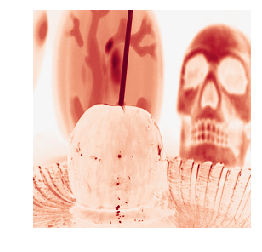

In [63]:
plot(xs[i])

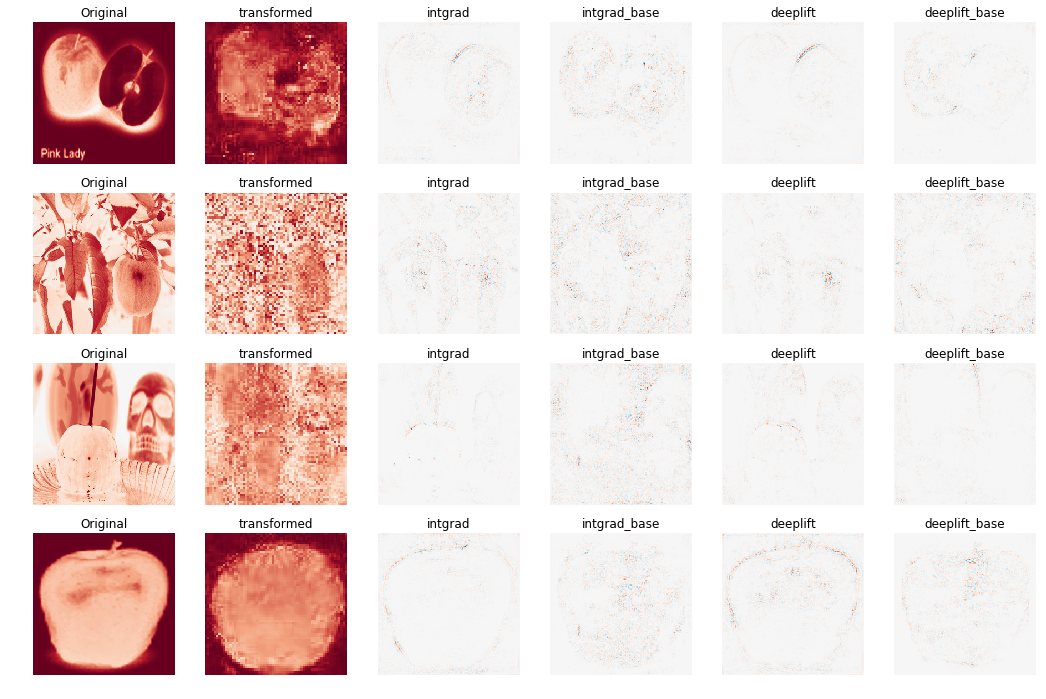

In [9]:
from utils import plot, plt

nrows = len(file_name)
ncols = 6
n_cols = ncols # 5
n_rows = nrows # 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*n_cols, 3*n_rows))
for i in range(nrows):
    a1 = attributions_ig[i]
    a2 = attributions_ig_base_line[i]
    a3 = attributions_dl[i]
    a4 = attributions_dl_base_line[i]
    plot(xs[i], axis=axes[i,0]).set_title('Original')
    plot(base_imag[i], axis=axes[i,1]).set_title('transformed')
    plot(a1, axis=axes[i,2]).set_title('intgrad')
    plot(a2, axis=axes[i,3]).set_title('intgrad_base')
    plot(a3, axis=axes[i,4]).set_title('deeplift')
    plot(a4, axis=axes[i, 5]).set_title('deeplift_base')
    


In [45]:
axes.shape

(2, 5)

In [ ]:
plot(xs[0], axis=axes[0]).set_title('Original')
plot(a1, axis=axes[1]).set_title('intgrad')
plot(a2, axis=axes[2]).set_title('intgrad_base')
plot(a3, axis=axes[3]).set_title('deeplift')
plot(a4, axis=axes[4]).set_title('deeplift_base')